In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import anndata
from scipy.stats import spearmanr, pearsonr
import numpy as np
from PIL import Image
import matplotlib

# Load configuration
with open("../config/config_notebooks.json", "r") as config_file:
    config = json.load(config_file)

Image.MAX_IMAGE_PIXELS = None
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

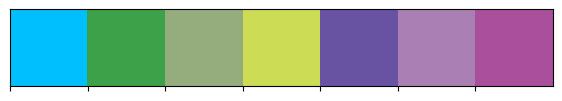

In [2]:
a = config["retrained_color_palette"]
sns.palplot(sns.color_palette(a))

In [ ]:
# This will give you the results for the FULL models.

model_type = config["retrained_model_list2_type"]
model_list = config["retrained_model_list2"]
benchmark_folder = config["retrained_benchmark_folder2"]
pairs_to_compare = [("uni", model) for model in model_list if model != "uni"]


models_palette = dict(zip(model_list, a))
models_palette["handcrafted_features"] = "lightgrey"

# UNCOMMENT TO GENERATE THE RESULTS FOR THE EXPLORA MODELS
# model_type = config["retrained_model_list1_type"]
# model_list = config["retrained_model_list1"]
# benchmark_folder = config["retrained_benchmark_folder1"]


In [4]:
def plot_ari_scores_all_patients(clustering_dict, model_list=None):

    if model_list is None:
        model_list = clustering_dict.keys()

    ari_scores = {}
    for model in model_list:
        ari_scores[model] = {}
        for patient in clustering_dict[model].keys():
            if (patient != 'all') and (patient != 'mean'):
                ari_scores[model][patient] = clustering_dict[model][patient]['ari']
    df_aris = pd.DataFrame.from_dict(ari_scores)
    df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
    df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)

    sns.boxplot(data=df_aris_melted, x='model', y='ari', color='white', linewidth=2)
    sns.stripplot(data=df_aris_melted, x='model', y='ari', jitter=True, dodge=True, linewidth=1, hue='patient', palette='Accent')
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    plt.title('ARI scores for unsupervised clustering', weight='bold')

## Comparison between linear and unlinear clustering

In [5]:
with open(os.path.join(benchmark_folder, 'unsupervised_clustering_ARI', 'unsupervised_clustering_results_optk.json')) as f:
    raw_clust = json.load(f)

with open(os.path.join(benchmark_folder,'unsupervised_clustering_ARI', 'svd5_multiplied_by_S_unsupervised_clustering_results_optk.json')) as f:
    svd_clust = json.load(f)

with open(os.path.join(benchmark_folder,'unsupervised_clustering_ARI', 'best_umap_ari_per_slide.json')) as f:
    umap_clust = json.load(f)

In [6]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari all: {raw_clust[model]['all']['ari']}, ari mean: {raw_clust[model]['mean']['ari']}")

Model: uni: ari all: 0.1405392782347744, ari mean: 0.2351268295263375
Model: uni_full_kde_4096_prototypes: ari all: 0.22435893962084028, ari mean: 0.19504631252412255
Model: uni_full_kde_16384_prototypes: ari all: 0.13403037034764706, ari mean: 0.19007796709910665
Model: uni_full_kde_65536_prototypes: ari all: 0.1009119945294695, ari mean: 0.16615053296027052
Model: uni_full_koleo_4096_prototypes: ari all: 0.246959512048176, ari mean: 0.1894203703846208
Model: uni_full_koleo_16384_prototypes: ari all: 0.1801047519580902, ari mean: 0.21054692645132875
Model: uni_full_koleo_65536_prototypes: ari all: 0.13071168730250624, ari mean: 0.18392541734273457
Model: handcrafted_features: ari all: 0.10094446204343024, ari mean: 0.11174721697791898


In [7]:
for model in raw_clust.keys():
    print(f"Model: {model}: ari tumor: {raw_clust[model]['ARI_tumor']}")

Model: uni: ari tumor: 0.14775572194802
Model: uni_full_kde_4096_prototypes: ari tumor: 0.18365074945187695
Model: uni_full_kde_16384_prototypes: ari tumor: 0.1890790502135067
Model: uni_full_kde_65536_prototypes: ari tumor: 0.1420053083676916
Model: uni_full_koleo_4096_prototypes: ari tumor: 0.17858172906558764
Model: uni_full_koleo_16384_prototypes: ari tumor: 0.18101867889344025
Model: uni_full_koleo_65536_prototypes: ari tumor: 0.13898538339225633
Model: handcrafted_features: ari tumor: 0.08584559722543653


Text(0.5, 1.0, 'umap kmeans -- full models')

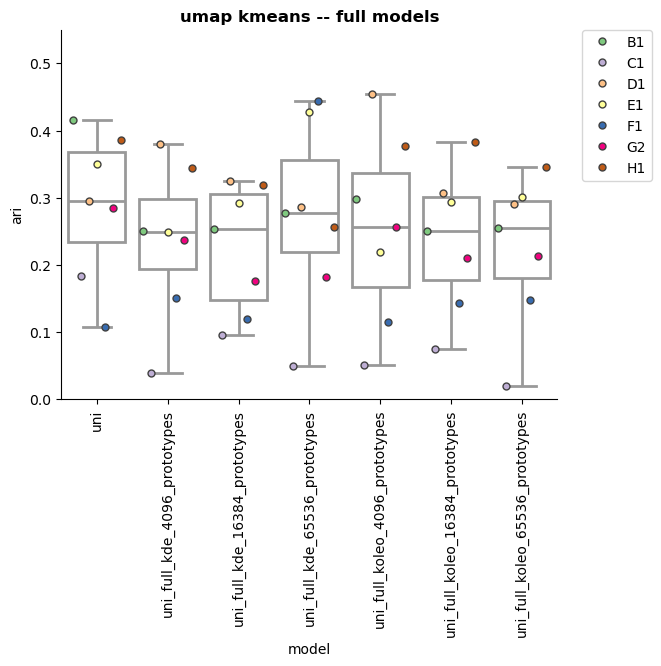

In [8]:
# for clust_dict, clust_name in zip([raw_clust, svd_clust, umap_clust], ["raw", "svd", "umap"]):

plt.figure()
plot_ari_scores_all_patients(umap_clust, model_list=model_list)
plt.ylim(0, 0.55)
plt.title(f"umap kmeans -- {model_type} models", weight='bold')

In [9]:
# Scatter plot

In [10]:
dfs_clust = []
for clustering_dict, method in zip([raw_clust, svd_clust, umap_clust], ["raw", "svd", "umap"]):
#for clustering_dict, method in zip([umap_clust], ["umap"]):
    ari_scores = {}
    for model in clustering_dict.keys():
        ari_scores[model] = {}
        for patient in clustering_dict[model].keys():
            #if (patient != 'all') and (patient != 'mean'):
            if (patient != 'ARI_tumor'):
                ari_scores[model][patient] = clustering_dict[model][patient]['ari']
    df_aris = pd.DataFrame.from_dict(ari_scores)
    df_aris_melted = pd.melt(df_aris, var_name='model', value_name='ari')
    df_aris_melted['patient'] = df_aris.index.to_list()*len(df_aris.columns)
    df_aris_melted['clustering'] = method
    dfs_clust.append(df_aris_melted)

df_comp = pd.concat(dfs_clust)




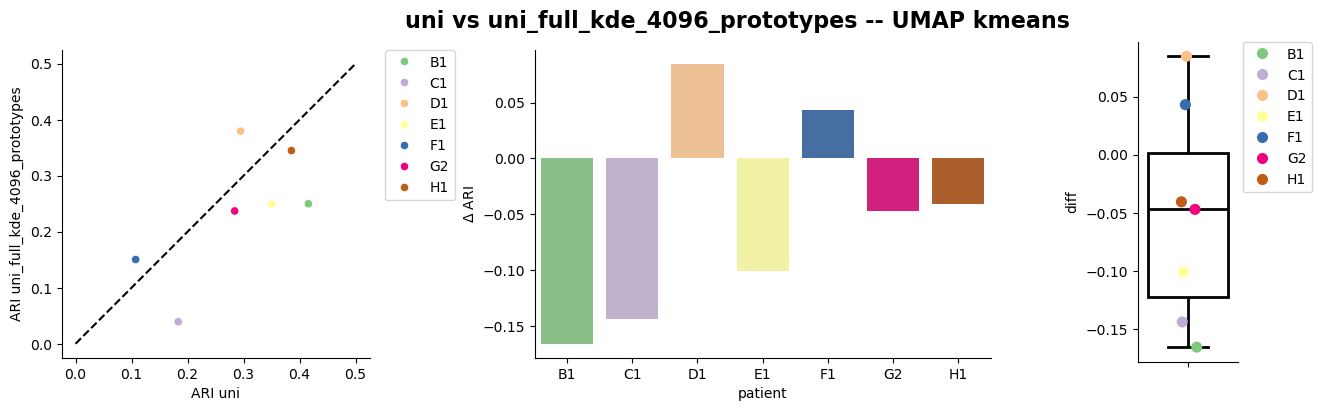

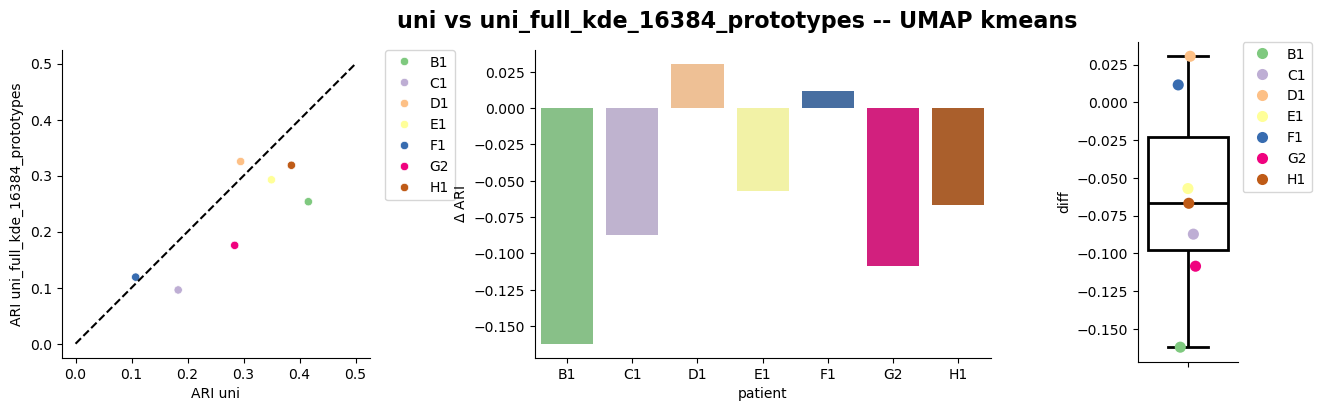

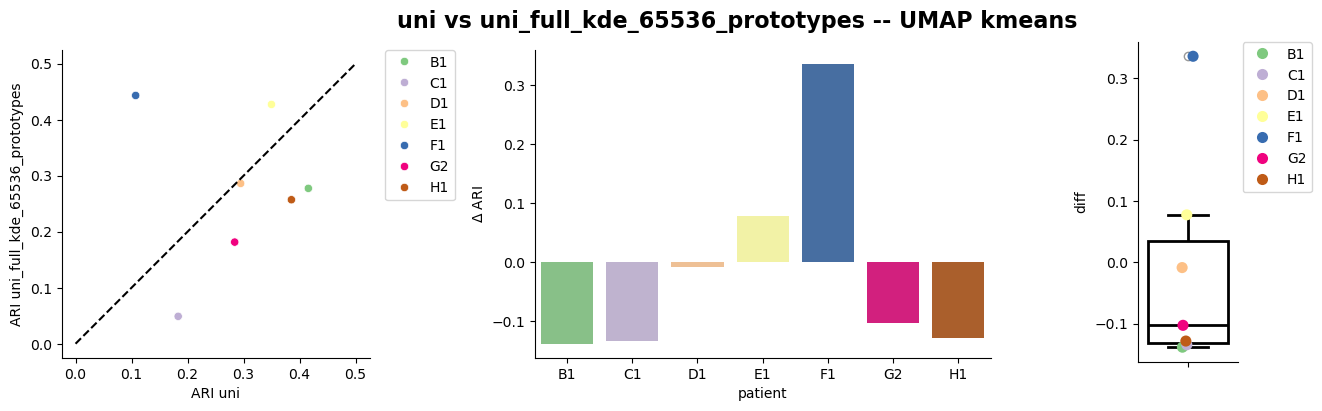

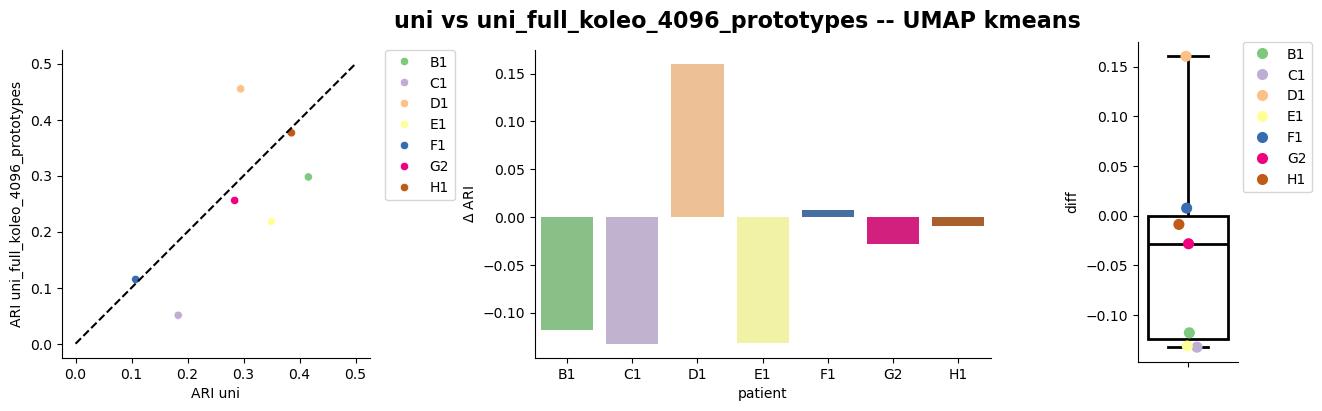

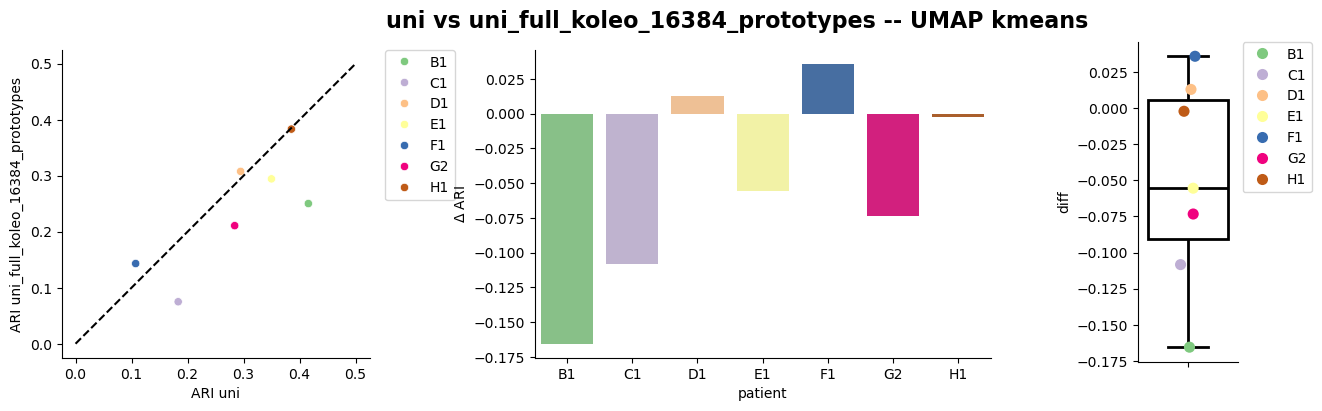

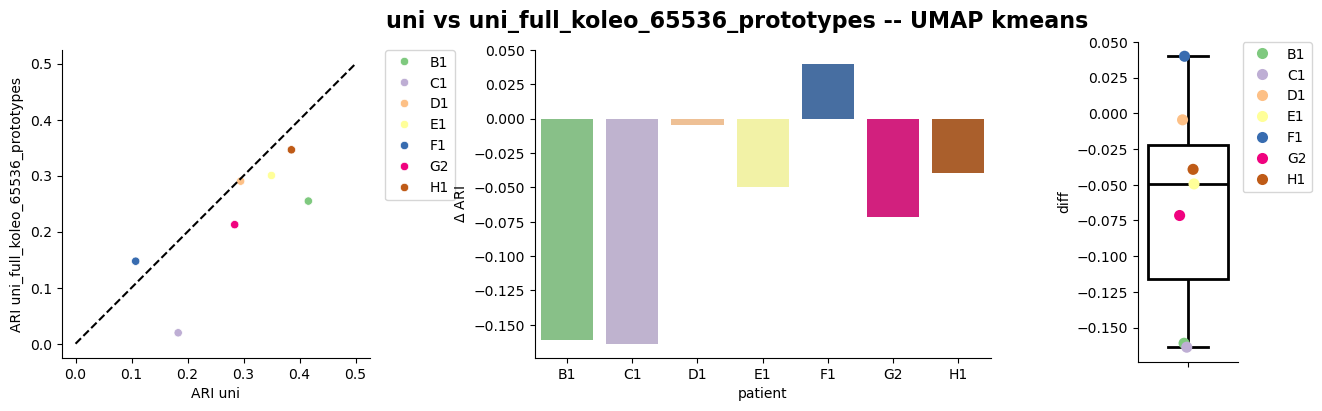

In [11]:
df_comps = {}
for clust_type in ['umap']:
  df_comps[clust_type] = {}
  for pair in pairs_to_compare:
    
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)

    df_sub_comp = df_comp[(df_comp['model'] == pair[1]) 
                            & (df_comp['clustering'] == clust_type) 
                            & (df_comp['patient'] != 'mean') 
                            & (df_comp['patient'] != 'all')].merge(df_comp[(df_comp['model'] == pair[0]) 
                                                                        & (df_comp['clustering'] == clust_type) 
                                                                        & (df_comp['patient'] != 'mean') 
                                                                        & (df_comp['patient'] != 'all')], 
                                                                        left_on='patient',
                                                                            right_on='patient', 
                                                                            suffixes=(f'_{pair[1]}', f'_{pair[0]}'))
    
    df_comps[clust_type][f"{pair[1]}"] = df_sub_comp
    
    plt.gca().set_aspect('equal', adjustable='box')
    sns.scatterplot(data=df_sub_comp, x=f'ari_{pair[0]}', y=f'ari_{pair[1]}', hue='patient', palette='Accent')
    plt.plot([0, 0.5], [0, 0.5], color='black', linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # plt.title(f'{pair[0]} vs {pair[1]}', weight='bold')
    plt.xlabel(f'ARI {pair[0]}')
    plt.ylabel(f'ARI {pair[1]}')
    sns.despine()

    plt.subplot(1, 3, 2)
    df_sub_comp['diff'] = df_sub_comp[f'ari_{pair[1]}'] - df_sub_comp[f'ari_{pair[0]}']
    sns.barplot(x='patient', y='diff', data=df_sub_comp, palette='Accent', hue='patient') 
    sns.despine()
    plt.ylabel(r'$\Delta$ ARI')
    # plt.title(f'Difference in ARI {pair[1]} - {pair[0]}', weight='bold')

    plt.subplot(1, 3, 3)
    plt.gca().set_position([0.7, 0.1, 0.05, 0.8])
    sns.boxplot(data=df_sub_comp, y='diff', color='white', linewidth=2,  boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'))
    sns.stripplot(data=df_sub_comp, y='diff', hue='patient', palette='Accent', linewidth=0, size=8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()

    plt.suptitle(f'{pair[0]} vs {pair[1]} -- {clust_type.upper()} kmeans', weight='bold', fontsize=16)
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/{pair[0]}_vs_{pair[1]}_{clust_type}_kmeans.pdf"), bbox_inches='tight')

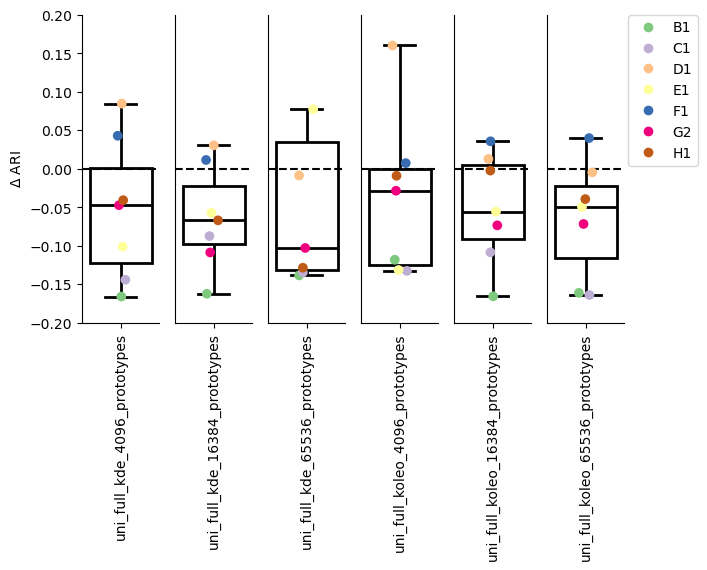

In [12]:
plt.figure(figsize=(7, 4))

df_comps = {}
for clust_type in ['umap']:
  df_comps[clust_type] = {}
  for i, pair in enumerate(pairs_to_compare):
    
    plt.subplot(1, len(pairs_to_compare), i+1)

    df_sub_comp = df_comp[(df_comp['model'] == pair[1]) 
                            & (df_comp['clustering'] == clust_type) 
                            & (df_comp['patient'] != 'mean') 
                            & (df_comp['patient'] != 'all')].merge(df_comp[(df_comp['model'] == pair[0]) 
                                                                        & (df_comp['clustering'] == clust_type) 
                                                                        & (df_comp['patient'] != 'mean') 
                                                                        & (df_comp['patient'] != 'all')], 
                                                                        left_on='patient',
                                                                            right_on='patient', 
                                                                            suffixes=(f'_{pair[1]}', f'_{pair[0]}'))
    
    df_comps[clust_type][f"{pair[1]}"] = df_sub_comp
    


    df_sub_comp['diff'] = df_sub_comp[f'ari_{pair[1]}'] - df_sub_comp[f'ari_{pair[0]}']

    #plt.gca().set_position([0.7, 0.1, 0.05, 0.8])
    sns.boxplot(data=df_sub_comp, y='diff', color='white', linewidth=2,  boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'))
    sns.stripplot(data=df_sub_comp, y='diff', hue='patient', palette='Accent', linewidth=0, size=7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    plt.xticks(ticks=[0], labels=[pair[1]], rotation=90)
    plt.ylim(-0.2, 0.2)
    
    plt.axhline(0, color='black', linestyle='--')
    plt.ylabel(r'$\Delta$ ARI')
    if i != 0:

        plt.gca().axes.get_yaxis().set_visible(False)
    
    if i != len(pairs_to_compare) -1:
        plt.legend().remove()
        

plt.savefig(os.path.join(config["figures_folder"], f"Figure2/boxplot_ARI_differences_per_patient_{clust_type}_kmeans_{model_type}_models.pdf"), bbox_inches='tight')


(0.0, 0.55)

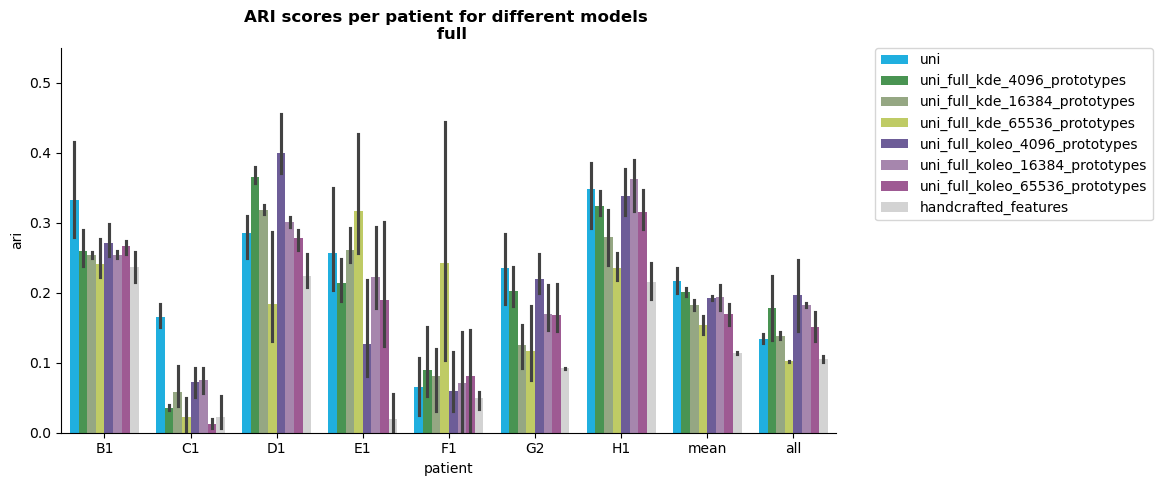

In [13]:


plt.figure(figsize=(10, 5))
sns.barplot(data=df_comp, x='patient', y='ari', hue='model', palette=models_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.title(f'ARI scores per patient for different models \n {model_type}', weight='bold')
plt.ylim(0, 0.55)

In [14]:
import math
def make_spider(df, row, color, title):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5))
 
    ax = plt.subplot(1,1,1, polar=True)
 
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    
 
   
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.tick_params(axis='x', rotation=5.5)
    
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.2,0.3,0.4], ["0.1","0.2","0.3","0.4"], color="black", size=10)
    plt.ylim(0,0.55)
 
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = 0.1)
 
  
    plt.title(title, fontsize=20, x = 0.5, y = 1.1)

In [15]:
df_comp_patient = df_comp[df_comp["patient"].isin(["A1", "B1", "C1", "D1", "E1", "F1", "G2", "H1"])]


In [16]:
df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').mean()

,ari
model,
handcrafted_features,0.110547
uni,0.224617
uni_full_kde_16384_prototypes,0.183850
uni_full_kde_4096_prototypes,0.198303
uni_full_kde_65536_prototypes,0.158902
uni_full_koleo_16384_prototypes,0.207164
uni_full_koleo_4096_prototypes,0.195814
uni_full_koleo_65536_prototypes,0.178013


In [17]:
df_comp[df_comp['clustering'] == 'raw'][['model', 'ari']].groupby('model').std()

,ari
model,
handcrafted_features,0.087322
uni,0.094085
uni_full_kde_16384_prototypes,0.094171
uni_full_kde_4096_prototypes,0.106414
uni_full_kde_65536_prototypes,0.075103
uni_full_koleo_16384_prototypes,0.097864
uni_full_koleo_4096_prototypes,0.114921
uni_full_koleo_65536_prototypes,0.095711


In [18]:

for value in df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').std().loc[model_list, 'ari']:
    print(f"{value:.2f}")


0.11
0.11
0.10
0.14
0.14
0.10
0.11


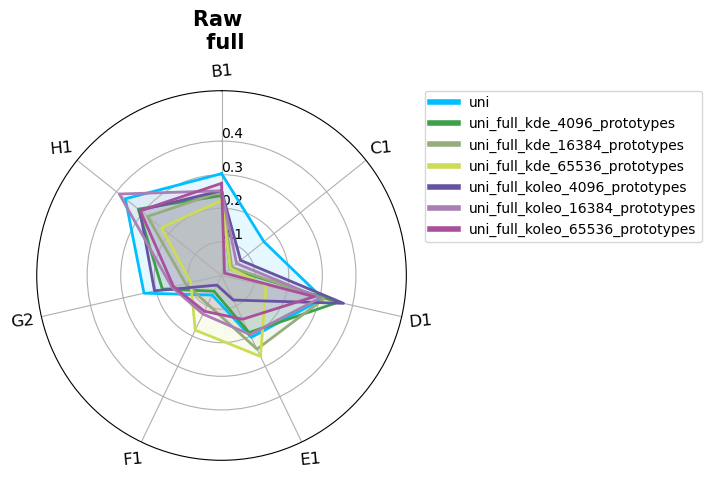

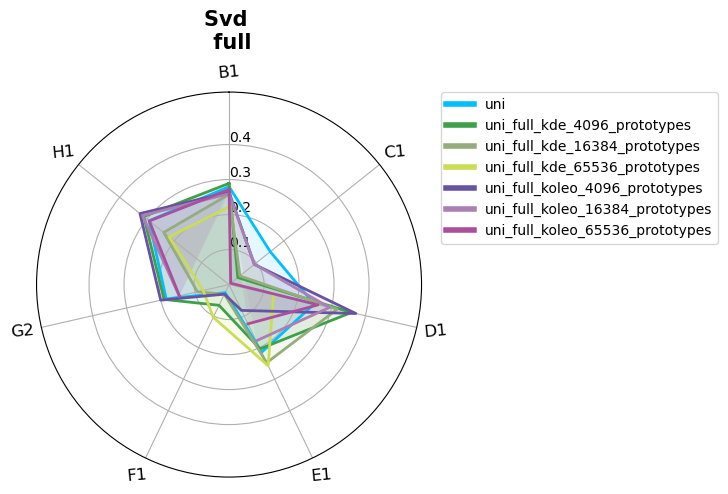

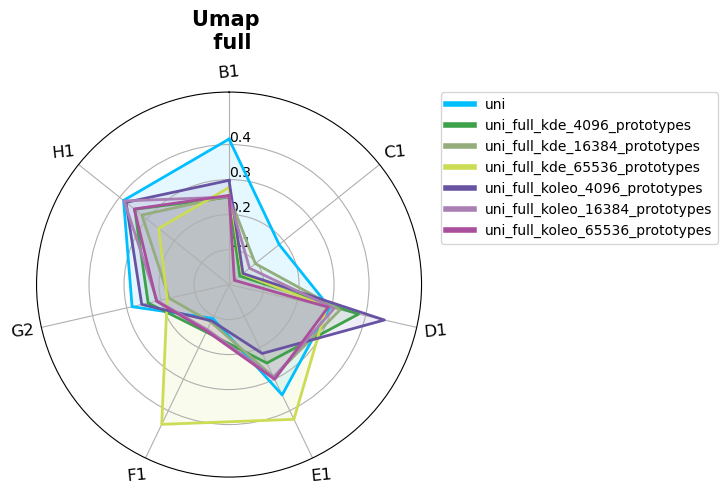

In [19]:
for clustering_technique in ['raw', 'svd', 'umap']:
    plt.figure()
    for i, model in enumerate(model_list):
        d_test = df_comp_patient[(df_comp_patient["model"] == model) & (df_comp_patient["clustering"] == clustering_technique)].T
        d_test.columns = d_test.loc['patient'].values
        make_spider(d_test, row=1, color=models_palette[model], title=model)
        plt.title(f"{clustering_technique.capitalize()} \n {model_type}", weight='bold', y=1.09, fontsize=15)

    handles = [plt.Line2D([0], [0], color=models_palette[model], lw=4) for model in model_list]
    plt.legend(handles, model_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/ari_scores_radar_plot_{clustering_technique}_{model_type}_models.pdf"), bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


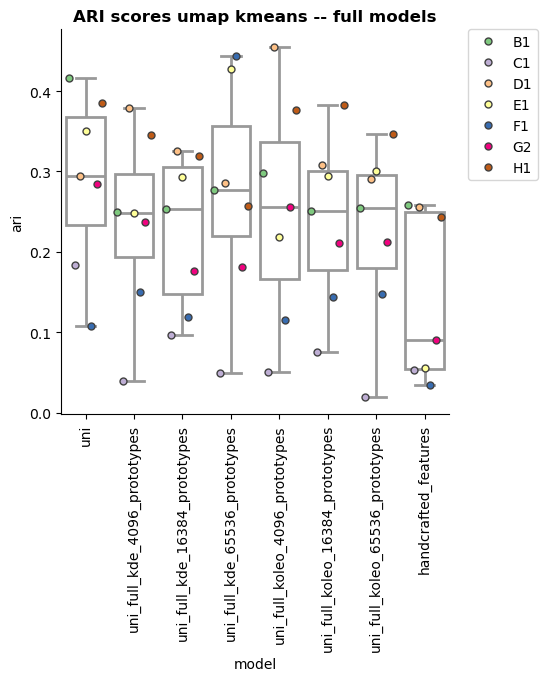

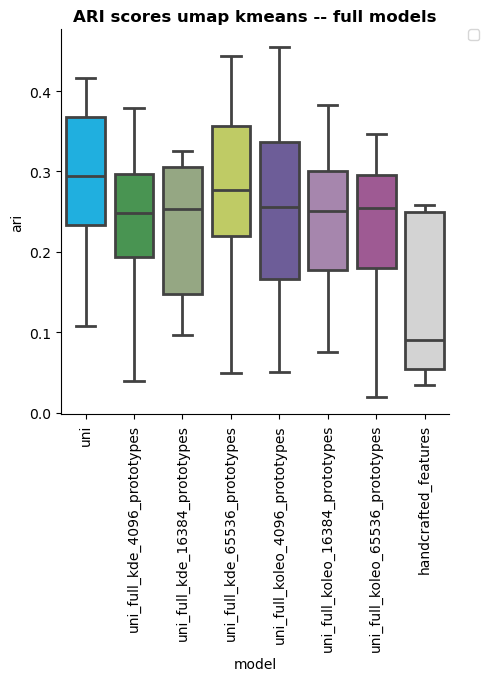

In [20]:
## 
sns.boxplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], x='model', y='ari', color='white', linewidth=2)
sns.stripplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], x='model', y='ari', jitter=True, dodge=True, linewidth=1, hue='patient', palette='Accent')
plt.xticks(rotation=90)
sns.despine()
plt.title('ARI scores for unsupervised clustering', weight='bold')
sns.despine()
plt.title(f"ARI scores umap kmeans -- {model_type} models", weight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/ari_scores_umap_kmeans_{model_type}_models_with_patient.pdf"), bbox_inches='tight')

## 
plt.figure()
sns.boxplot(data=df_comp_patient[df_comp_patient['clustering'] == 'umap'], 
            x='model', y='ari', hue='model', linewidth=2, palette=models_palette)
plt.xticks(rotation=90)
sns.despine()
plt.title('ARI scores for unsupervised clustering', weight='bold')
sns.despine()
plt.title(f"ARI scores umap kmeans -- {model_type} models", weight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/ari_scores_umap_kmeans_{model_type}_models_colors.pdf"), bbox_inches='tight')

In [21]:

for i, model in enumerate(df_comp['model'].unique()):
    print(model)
    sub_df = df_comp[(df_comp['model'] == model) & (df_comp['clustering'] == 'umap')][['ari', 'patient']].rename(columns = {'ari': model})
    # dfs.append(sub_df)
    if i > 0:
        df = df.merge(sub_df, on='patient')
    else:
        df = sub_df.copy()

df.set_index('patient', inplace=True)
df_delta_ari = df.apply(lambda x: x - df['uni'])
df_delta_ari.drop('uni', axis=1, inplace=True) 

uni
uni_full_kde_4096_prototypes
uni_full_kde_16384_prototypes
uni_full_kde_65536_prototypes
uni_full_koleo_4096_prototypes
uni_full_koleo_16384_prototypes
uni_full_koleo_65536_prototypes
handcrafted_features


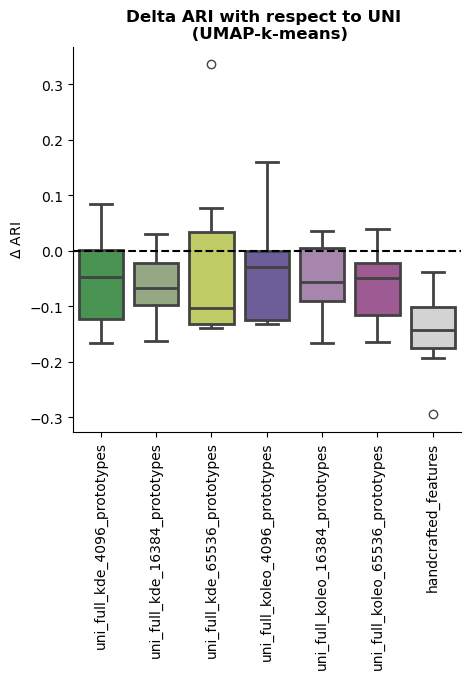

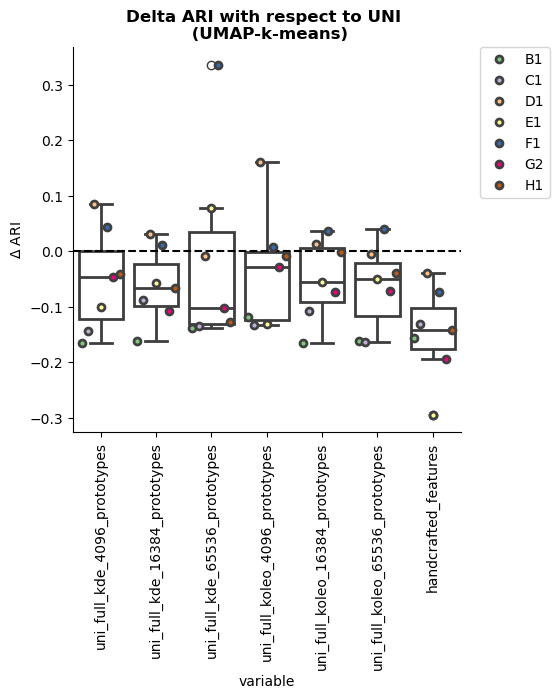

In [22]:
# plot delta ARI
plt.figure()
sns.boxplot(data=df_delta_ari, palette=models_palette, linewidth=2)
plt.title(f'Delta ARI with respect to UNI \n (UMAP-k-means)', weight='bold')
plt.ylabel(r'$\Delta$ ARI')
sns.despine()
plt.xticks(rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/delta_umap_ari_scores_boxplot_{model_type}_models_colors.pdf"), bbox_inches='tight')

plt.figure()
sns.boxplot(data=df_delta_ari, color='white', linewidth=2)
# sns.stripplot(data=df_delta_ari.reset_index(), palette='Accent', hue='index')
df_long = df_delta_ari.reset_index().melt(id_vars=['patient'], var_name='variable', value_name='value')

# Create the strip plot
sns.stripplot(data=df_long, x='variable', y='value', jitter=True, dodge=True, linewidth=2, palette='Accent', hue='patient')
plt.title(f'Delta ARI with respect to UNI \n (UMAP-k-means)', weight='bold')
plt.ylabel(r'$\Delta$ ARI')
sns.despine()
plt.xticks(rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/delta_umap_ari_scores_boxplot_{model_type}_models_with_patient.pdf"), bbox_inches='tight')

In [23]:
## Correlation with shannon entropy
import json 

with open(os.path.join(benchmark_folder, "shannon_entropy", "shannon_entropy_all_comps_raw.json")) as f:
    shannon_entropy = json.load(f)

In [24]:
df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])


In [25]:
df_shannon.rename(index={'handcrafted': 'handcrafted_features'}, inplace=True)

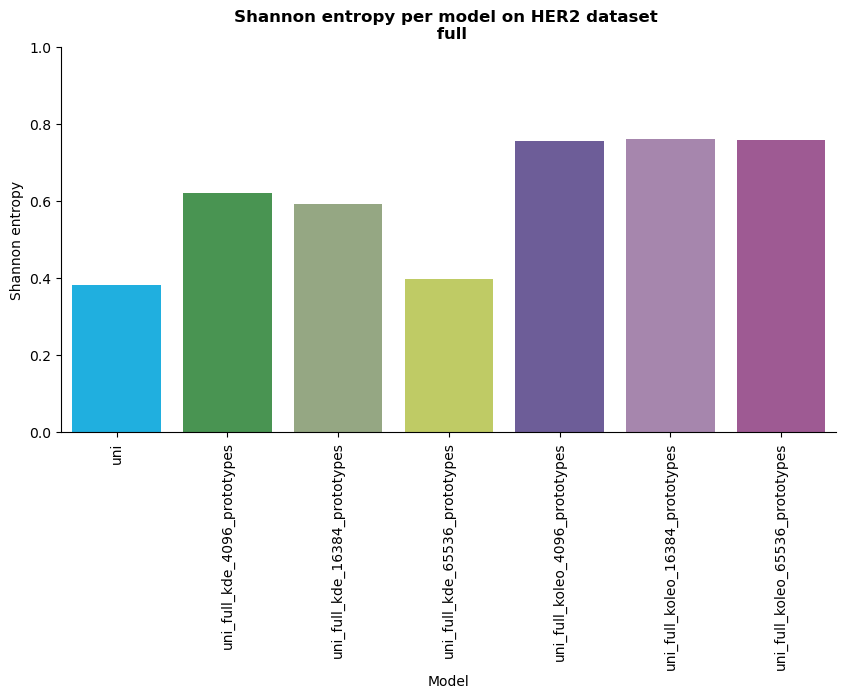

In [26]:
# df_shannon.sort_values('shannon_entropy', inplace=True, ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_shannon, 
            x=df_shannon.index, 
            y='shannon_entropy', 
            hue=df_shannon.index, palette=models_palette)
sns.despine()
plt.xlabel("Model")
plt.ylabel("Shannon entropy")
plt.title(f"Shannon entropy per model on HER2 dataset \n {model_type}", weight='bold')
plt.xticks(rotation=90)
plt.ylim(0,1)
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/shannon_entropy_per_model_{model_type}.pdf"), bbox_inches='tight')

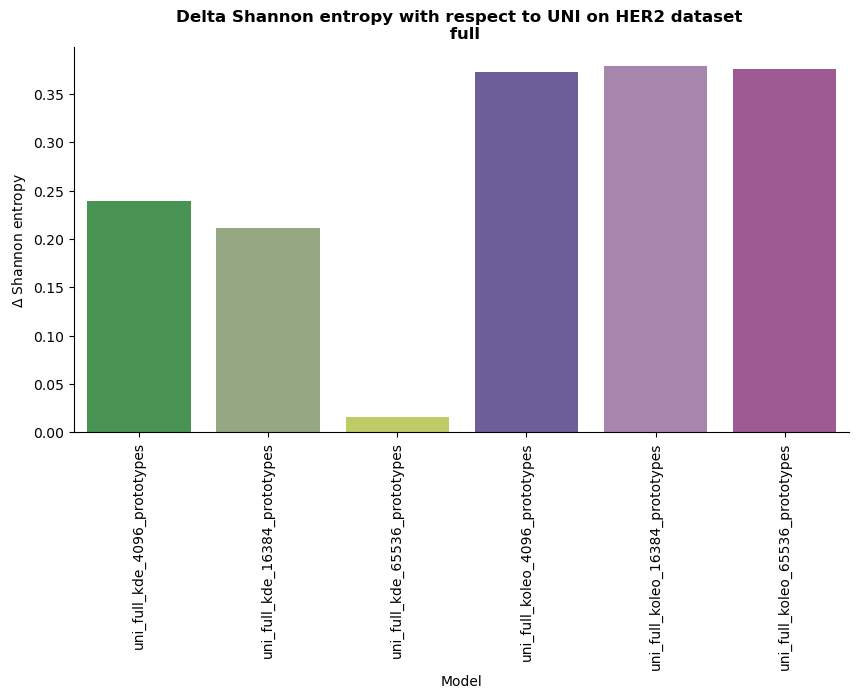

In [27]:
df_shannon_delta = df_shannon.copy()
df_shannon_delta = df_shannon_delta - df_shannon.loc['uni']
df_shannon_delta.drop('uni', inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_shannon_delta, 
            x=df_shannon_delta.index, 
            y='shannon_entropy', 
            hue=df_shannon_delta.index, palette=models_palette)
sns.despine()
plt.xlabel("Model")
plt.ylabel(r"$\Delta$ Shannon entropy")
plt.title(f"Delta Shannon entropy with respect to UNI on HER2 dataset \n {model_type}", weight='bold')
plt.xticks(rotation=90)
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/delta_shannon_entropy_per_model_{model_type}_barplot.pdf"), bbox_inches='tight')





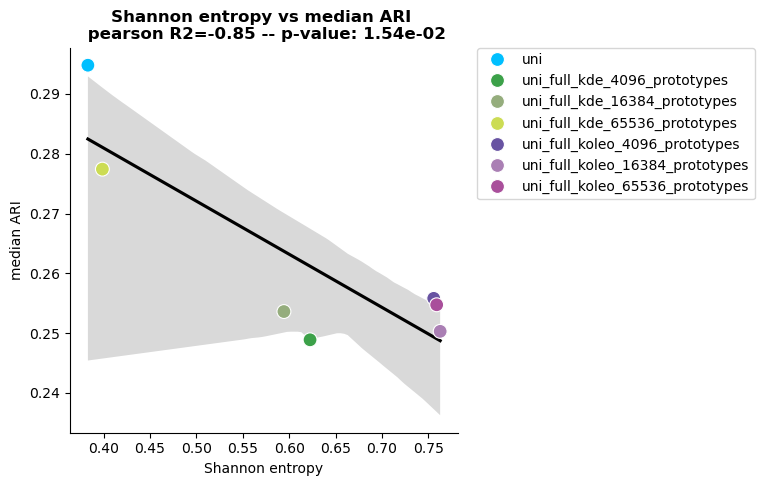

In [28]:
from scipy.stats import spearmanr, pearsonr

df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])

median_ari_per_model = df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').median()
median_ari_per_model.columns = ['median_ari']

df_model_summary = df_shannon.merge(median_ari_per_model, left_index=True, right_index=True)

# df_model_summary = df_model_summary.drop(["uni_full_4096_prototypes"])

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['median_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='median_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='median_ari', hue=df_model_summary.index,
                palette=models_palette, zorder=2, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('median ARI')
plt.title(f'Shannon entropy vs median ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/shannon_entropy_vs_median_ari_{model_type}_models.pdf"), bbox_inches='tight')

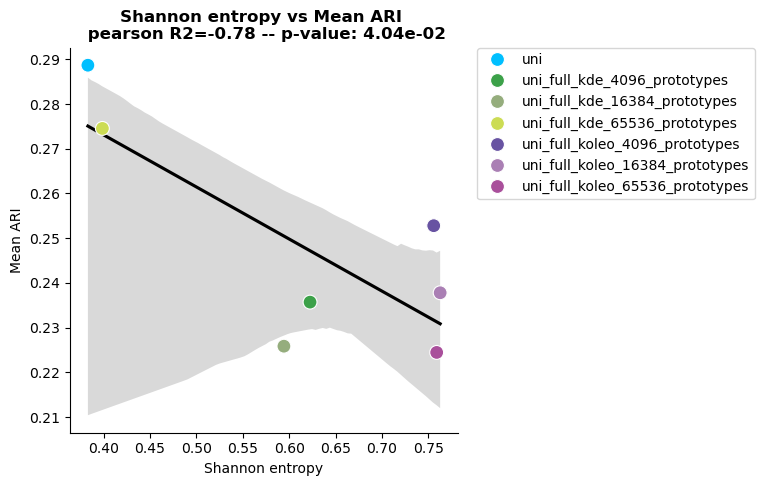

In [29]:

df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])

mean_ari_per_model = df_comp[df_comp['clustering'] == 'umap'][['model', 'ari']].groupby('model').mean()
mean_ari_per_model.columns = ['mean_ari']

df_model_summary = df_shannon.merge(mean_ari_per_model, left_index=True, right_index=True)

# df_model_summary = df_model_summary.drop(["uni_full_4096_prototypes"])

s, p = pearsonr(df_model_summary['shannon_entropy'], df_model_summary['mean_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='mean_ari', hue=df_model_summary.index,
                palette=models_palette, zorder=2, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Mean ARI')
plt.title(f'Shannon entropy vs Mean ARI \n pearson R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/shannon_entropy_vs_mean_ari_{model_type}_models.pdf"), bbox_inches='tight')

In [30]:
with open(os.path.join(benchmark_folder, 'unsupervised_clustering_ARI', "best_umap_ari_overall_annotated_only.json")) as f:
    overall_umap = json.load(f)

overall_umap_aris = {}
for model in overall_umap.keys():
    overall_umap_aris[model] = overall_umap[model]['ari']

df_model_summary['overall_ari'] = pd.Series(overall_umap_aris)

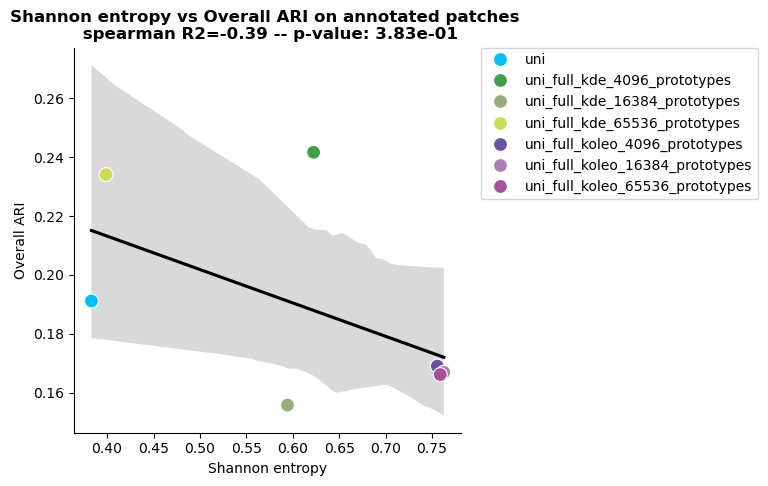

In [31]:
s, p = spearmanr(df_model_summary['shannon_entropy'], df_model_summary['overall_ari'])
plt.figure(figsize=(5, 5))
sns.regplot(data=df_model_summary, x='shannon_entropy', y='overall_ari', color='black')
sns.scatterplot(data=df_model_summary, x='shannon_entropy', y='overall_ari', hue=df_model_summary.index,
                palette=models_palette, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Shannon entropy')
plt.ylabel('Overall ARI')
plt.title(f'Shannon entropy vs Overall ARI on annotated patches \n spearman R2={s:.2f} -- p-value: {p:.2e}', weight='bold')
sns.despine()
plt.savefig(os.path.join(config["figures_folder"], f"Figure2/shannon_entropy_vs_overall_ari_{model_type}_models.pdf"), bbox_inches='tight')

In [32]:
from scipy.stats import entropy
from digitalhistopathology.benchmark.benchmark_base import BenchmarkBase

benchmark_HER2 = BenchmarkBase(path_to_pipeline=[config['path_to_base_pipelines'][0]],
                                        pipelines_list=[config['base_model_list'][0]],
                                        dataset_name="her2_final_without_A",
                                        saving_folder=config['base_benchmark_folder'])

benchmark_HER2.compute_image_embeddings()

2025-05-02 17:29:29.581992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2025-05-02 17:29:29.582095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2025-05-02 17:29:29.582107: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.
['uni']
<class 'list'>
Label files: ['../data/HER2_breast_cancer/meta/D1_labeled_coordinates.tsv', '../data/HER2_breast_cancer/meta/H1_labeled_coordinates.tsv', '../data/HER2_breast_cancer/meta/E1_labeled_coordinates.tsv', '../data/HER2_breast_cancer/meta/A1_labeled_coordinates.tsv', '../data/HER2_breast_cancer/meta/C1_labeled_coordinates.tsv', '../data/HER2_breast_cancer/meta/G2_labeled_coordinates.tsv', '../data/HER2_breast_cancer/meta/F1_labeled_coordinates.tsv', '../data/HER2_breast_cancer/meta/B1_labeled_coordinates.tsv']


In [33]:
proportions_invasive = {}
entropy_slide = {}
for slide in benchmark_HER2.image_embeddings['uni'].emb.obs['name_origin'].unique():
    #if slide != 'C1':
    value_counts = benchmark_HER2.image_embeddings['uni'].emb.obs[benchmark_HER2.image_embeddings['uni'].emb.obs['name_origin'] == slide]['label'].value_counts()
    value_counts.drop('nan', inplace=True)
    if value_counts.sum() == 0:
        continue
    proportion_invasive = value_counts['invasive cancer'] *100 / value_counts.sum()
    proportions_invasive[slide] = proportion_invasive
    entropy_slide[slide] = entropy(value_counts)
    print(f"Slide: {slide}; proportion of invasive cancer: {proportion_invasive}; entropy: {entropy(value_counts)}")



Slide: B1; proportion of invasive cancer: 21.35593220338983; entropy: 1.5242722236903004
Slide: C1; proportion of invasive cancer: 72.31638418079096; entropy: 0.7821684070846902
Slide: D1; proportion of invasive cancer: 45.30744336569579; entropy: 1.1096122483433783
Slide: E1; proportion of invasive cancer: 57.921635434412266; entropy: 0.9974948182603686
Slide: F1; proportion of invasive cancer: 83.50217076700434; entropy: 0.6198927306642088
Slide: G2; proportion of invasive cancer: 29.978586723768736; entropy: 1.6799723753896851
Slide: H1; proportion of invasive cancer: 14.681892332789559; entropy: 1.8083916353421718


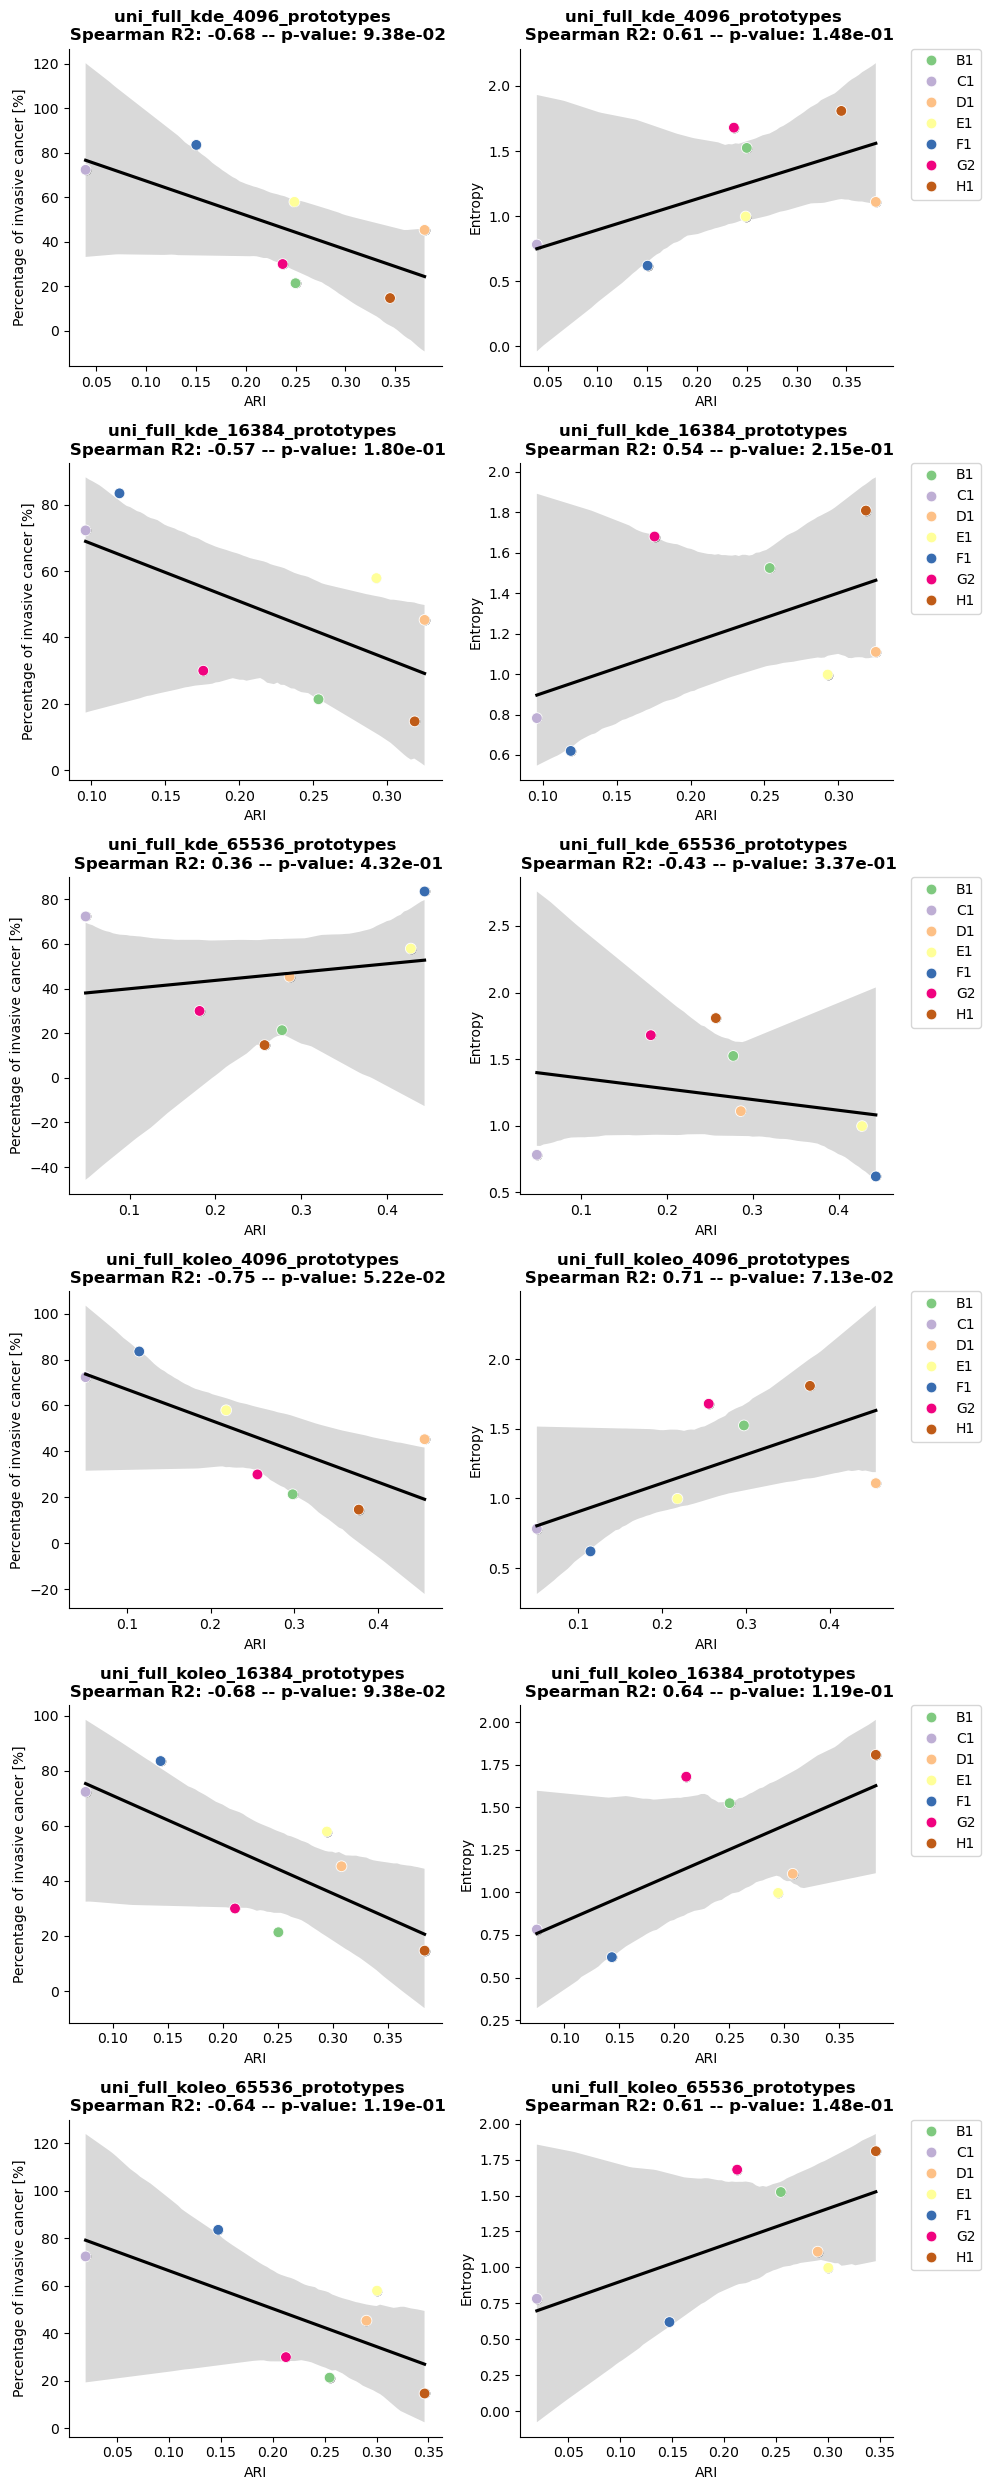

In [34]:
df = pd.DataFrame()
for model, model_scores in umap_clust.items():
    df[model] = [umap_clust[model][patient]['ari'] for patient in umap_clust[model].keys() if patient != 'all' and patient != 'mean']

df.index = [patient for patient in umap_clust['uni'].keys() if patient != 'all' and patient != 'mean']

plt.figure(figsize=(10, 25))
for i, model in enumerate([model for model in model_list if model != "uni"]):
    plt.subplot(len([model for model in model_list if model != "uni"]), 2, i*2+1)
    s, p = spearmanr(df[model], list(proportions_invasive.values()))
    sns.regplot(x=df[model], y=list(proportions_invasive.values()), color='black', x_ci="sd")
    sns.scatterplot(x=df[model], y=proportions_invasive.values(), hue=df.index, palette='Accent', s=60)
    plt.legend().remove()
    plt.title(f"{model} \n Spearman R2: {s:.2f} -- p-value: {p:.2e}", weight='bold')
    plt.xlabel('ARI')
    plt.ylabel('Percentage of invasive cancer [%]')
    sns.despine()

    plt.subplot(len([model for model in model_list if model != "uni"]), 2, i*2+2)
    s, p = spearmanr(df[model], list(entropy_slide.values()))
    sns.regplot(x=df[model], y=list(entropy_slide.values()), color='black', x_ci='sd')
    sns.scatterplot(x=df[model], y=entropy_slide.values(), hue=df.index, palette='Accent', s=60)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(f"{model} \n Spearman R2: {s:.2f} -- p-value: {p:.2e}", weight='bold')
    plt.xlabel('ARI')
    plt.ylabel('Entropy')
    sns.despine()



plt.tight_layout()
plt.savefig(os.path.join(config['figures_folder'], f"Figure3/ari_per_patient_vs_slide_entropy_and_pct_cancer_{model_type}_models.pdf"), bbox_inches='tight')


## Comparison between full and explora

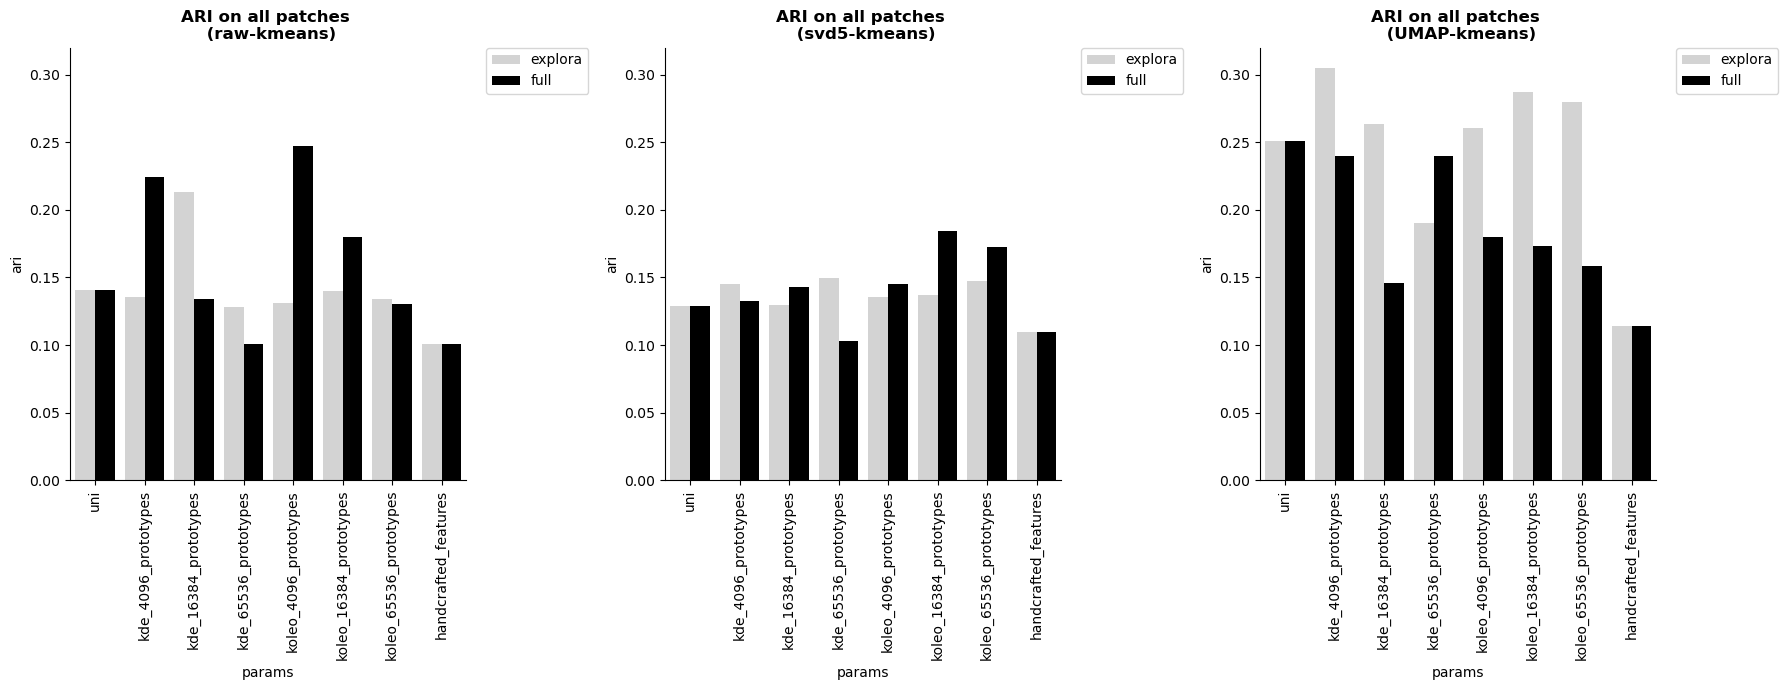

In [35]:
plt.figure(figsize=(18, 7))

##################### RAW #####################
plt.subplot(1,3,1)
with open(os.path.join(config['retrained_benchmark_folder2'], 'unsupervised_clustering_ARI', 'unsupervised_clustering_results_optk.json')) as f:
    ari_overall_full = json.load(f)

    aris = {}
    for model in ari_overall_full.keys():
        aris[model] = ari_overall_full[model]['all']['ari']
        
    df_ari_full = pd.DataFrame(aris, index=['ari']).T
    df_ari_full['model_type'] = config['retrained_model_list2_type']

with open(os.path.join(config['retrained_benchmark_folder1'], 'unsupervised_clustering_ARI', 'unsupervised_clustering_results_optk.json')) as f:
    ari_overall_explora= json.load(f)
    
    aris = {}
    for model in ari_overall_explora.keys():
        aris[model] = ari_overall_explora[model]['all']['ari']
        
    df_ari_explora = pd.DataFrame(aris, index=['ari']).T
    df_ari_explora['model_type'] = config['retrained_model_list1_type']

df = pd.concat([df_ari_explora, df_ari_full])
df["params"] = ["_".join(idx.split("_")[2:])  if "prototypes" in idx else idx for idx in df.index]
sns.barplot(data=df, x="params", y="ari", hue="model_type", palette=['lightgray', 'black'])
plt.xticks(rotation=90)

plt.title(f"ARI on all patches \n (raw-kmeans)", weight='bold')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.ylim(0, 0.32)

###################### SVD #####################
plt.subplot(1,3,2)

with open(os.path.join(config['retrained_benchmark_folder2'], 'unsupervised_clustering_ARI', 'svd5_multiplied_by_S_unsupervised_clustering_results_optk.json')) as f:
    ari_overall_full = json.load(f)

    aris = {}
    for model in ari_overall_full.keys():
        aris[model] = ari_overall_full[model]['all']['ari']
        
    df_ari_full = pd.DataFrame(aris, index=['ari']).T
    df_ari_full['model_type'] = config['retrained_model_list2_type']

with open(os.path.join(config['retrained_benchmark_folder1'], 'unsupervised_clustering_ARI', 'svd5_multiplied_by_S_unsupervised_clustering_results_optk.json')) as f:
    ari_overall_explora= json.load(f)
    
    aris = {}
    for model in ari_overall_explora.keys():
        aris[model] = ari_overall_explora[model]['all']['ari']
        
    df_ari_explora = pd.DataFrame(aris, index=['ari']).T
    df_ari_explora['model_type'] = config['retrained_model_list1_type']

df = pd.concat([df_ari_explora, df_ari_full])
df["params"] = ["_".join(idx.split("_")[2:])  if "prototypes" in idx else idx for idx in df.index]
sns.barplot(data=df, x="params", y="ari", hue="model_type", palette=['lightgray', 'black'])
plt.xticks(rotation=90)

plt.title(f"ARI on all patches \n (svd5-kmeans)", weight='bold')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.ylim(0, 0.32)

#################### UMAP #####################
plt.subplot(1,3,3)
with open(os.path.join(config['retrained_benchmark_folder2'], 'unsupervised_clustering_ARI', 'best_umap_ari_overall.json')) as f:
    ari_overall_full = json.load(f)

df_ari_overall_full = pd.DataFrame(ari_overall_full).T[['ari']]
df_ari_overall_full['model_type'] = config['retrained_model_list2_type']
df_ari_overall_full['dataset'] = df_ari_overall_full.index


with open(os.path.join(config['retrained_benchmark_folder1'], 'unsupervised_clustering_ARI', 'best_umap_ari_overall.json')) as f:
    ari_overall_explora= json.load(f)

df_ari_overall_explora = pd.DataFrame(ari_overall_explora).T[['ari']]
df_ari_overall_explora['model_type'] = config['retrained_model_list1_type']
df_ari_overall_explora['dataset'] = df_ari_overall_explora.index



df = pd.concat([df_ari_overall_explora, df_ari_overall_full])
df["params"] = ["_".join(idx.split("_")[2:])  if "prototypes" in idx else idx for idx in df.index]
sns.barplot(data=df, x="params", y="ari", hue="model_type", palette=['lightgray', 'black'])
plt.xticks(rotation=90)

plt.title(f"ARI on all patches \n (UMAP-kmeans)", weight='bold')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.ylim(0, 0.32)

plt.savefig(os.path.join(config["figures_folder"], "Figure2/ARI_scores_all_patches_full_vs_explora_models_raw_svd5_umap.pdf"), bbox_inches='tight')

In [36]:
df.head(1)

,ari,model_type,dataset,params
uni,0.250911,explora,uni,uni


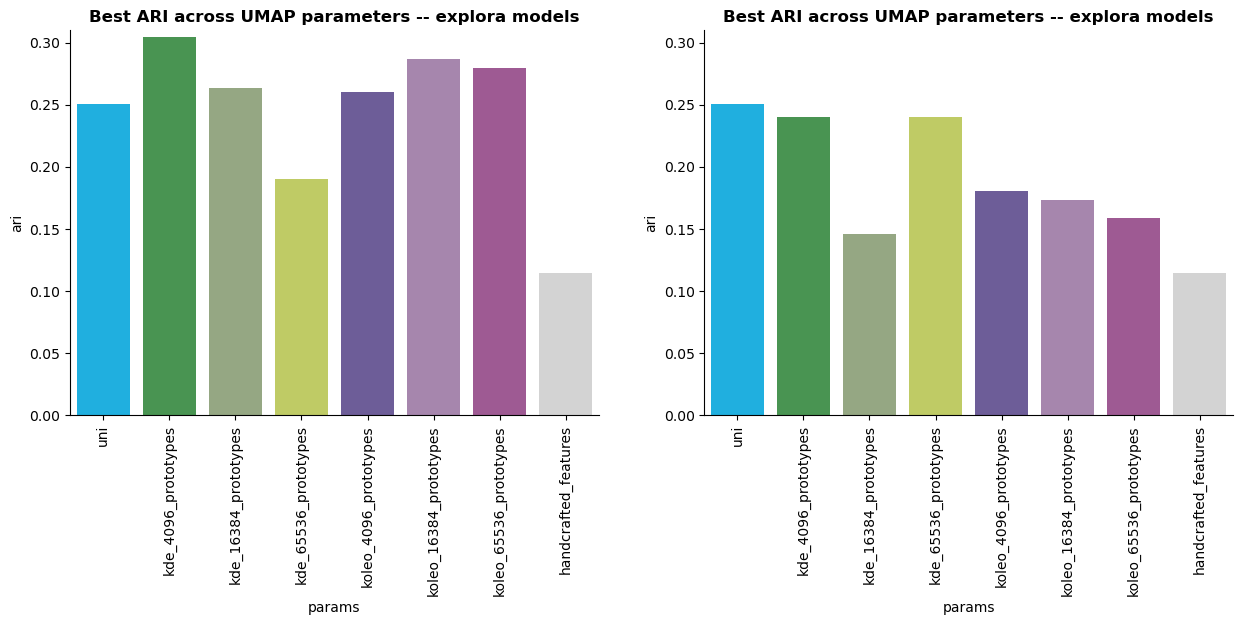

In [37]:
plt.figure(figsize=(15, 5), )

plt.subplot(1, 2, 1)
sns.barplot(data=df[df['model_type'] == config['retrained_model_list1_type']], x="params", y="ari", hue="params", palette=a+['lightgrey'])
plt.xticks(rotation=90)
plt.title(f"Best ARI across UMAP parameters -- {config['retrained_model_list1_type']} models", weight='bold')
sns.despine()
plt.ylim(0, 0.31)

plt.subplot(1, 2, 2)
sns.barplot(data=df[df['model_type'] == config['retrained_model_list2_type']], x="params", y="ari", hue="params", palette=a+['lightgrey'])
plt.xticks(rotation=90)
plt.title(f"Best ARI across UMAP parameters -- {config['retrained_model_list1_type']} models", weight='bold')
sns.despine()
plt.ylim(0, 0.31)
plt.savefig(os.path.join(config["figures_folder"], "Figure3/best_ari_across_umap_parameters_full_vs_explora_models.pdf"), bbox_inches='tight')

In [44]:
with open(os.path.join(config['retrained_benchmark_folder2'], 'unsupervised_clustering_ARI', 'unsupervised_clustering_results_optk.json')) as f:
    ari_overall_full = json.load(f)

    aris = {}
    for model in ari_overall_full.keys():
        aris[model] = ari_overall_full[model]['all']['ari']
        
    df_ari_full = pd.DataFrame(aris, index=['ari']).T
    df_ari_full['model_type'] = config['retrained_model_list2_type']

with open(os.path.join(config['retrained_benchmark_folder1'], 'unsupervised_clustering_ARI', 'unsupervised_clustering_results_optk.json')) as f:
    ari_overall_explora= json.load(f)
    
    aris = {}
    for model in ari_overall_explora.keys():
        aris[model] = ari_overall_explora[model]['all']['ari']
        
    df_ari_explora = pd.DataFrame(aris, index=['ari']).T
    df_ari_explora['model_type'] = config['retrained_model_list1_type']

df = pd.concat([df_ari_explora, df_ari_full])
df["params"] = ["_".join(idx.split("_")[2:])  if "prototypes" in idx else idx for idx in df.index]

In [45]:
df_ari_explora_delta = df_ari_explora.copy()
df_ari_explora_delta = df_ari_explora_delta['ari'] - df_ari_explora.loc['uni', 'ari']
df_ari_explora_delta

uni                                   0.000000
uni_explora_kde_4096_prototypes      -0.004870
uni_explora_kde_16384_prototypes      0.072664
uni_explora_kde_65536_prototypes     -0.012425
uni_explora_koleo_4096_prototypes    -0.009731
uni_explora_koleo_16384_prototypes   -0.000691
uni_explora_koleo_65536_prototypes   -0.006171
handcrafted_features                 -0.039595
Name: ari, dtype: float64

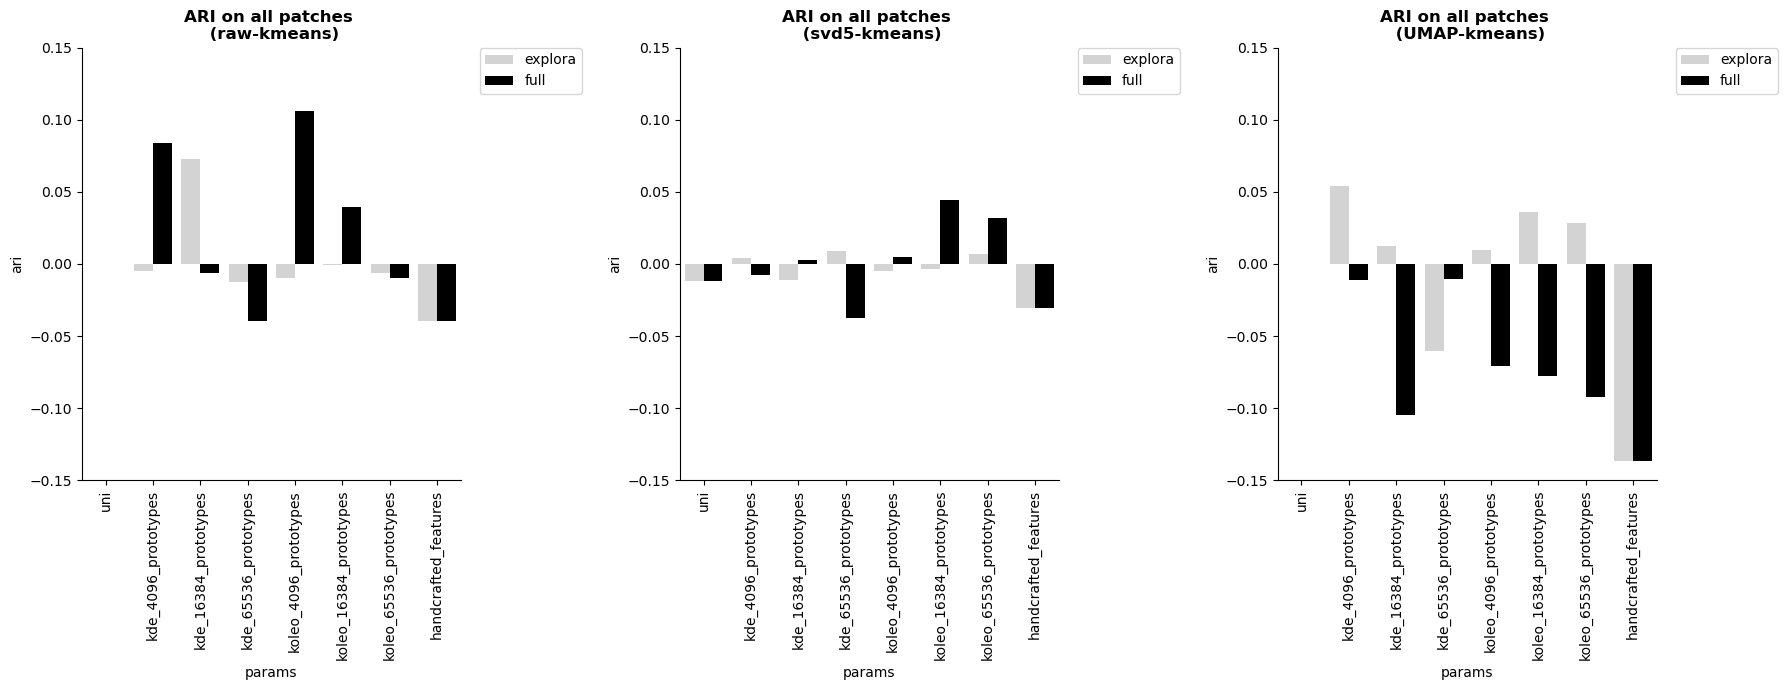

In [46]:
plt.figure(figsize=(18, 7))

##################### RAW #####################
plt.subplot(1,3,1)
with open(os.path.join(config['retrained_benchmark_folder2'], 'unsupervised_clustering_ARI', 'unsupervised_clustering_results_optk.json')) as f:
    ari_overall_full = json.load(f)

    aris = {}
    for model in ari_overall_full.keys():
        aris[model] = ari_overall_full[model]['all']['ari']
        
    df_ari_full_delta = pd.DataFrame(aris, index=['ari']).T
    df_ari_full_delta['model_type'] = config['retrained_model_list2_type']
    df_ari_full_delta['ari'] = df_ari_full_delta['ari'] - df_ari_full.loc['uni', 'ari']

with open(os.path.join(config['retrained_benchmark_folder1'], 'unsupervised_clustering_ARI', 'unsupervised_clustering_results_optk.json')) as f:
    ari_overall_explora= json.load(f)
    
    aris = {}
    for model in ari_overall_explora.keys():
        aris[model] = ari_overall_explora[model]['all']['ari']
        
    df_ari_explora_delta = pd.DataFrame(aris, index=['ari']).T
    df_ari_explora_delta['model_type'] = config['retrained_model_list1_type']
    df_ari_explora_delta['ari'] = df_ari_explora_delta['ari'] - df_ari_explora.loc['uni', 'ari']

df = pd.concat([df_ari_explora_delta, df_ari_full_delta])
df["params"] = ["_".join(idx.split("_")[2:])  if "prototypes" in idx else idx for idx in df.index]
sns.barplot(data=df, x="params", y="ari", hue="model_type", palette=['lightgray', 'black'])
plt.xticks(rotation=90)

plt.title(f"ARI on all patches \n (raw-kmeans)", weight='bold')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.ylim(-0.15, 0.15)

###################### SVD #####################
plt.subplot(1,3,2)

with open(os.path.join(config['retrained_benchmark_folder2'], 'unsupervised_clustering_ARI', 'svd5_multiplied_by_S_unsupervised_clustering_results_optk.json')) as f:
    ari_overall_full = json.load(f)

    aris = {}
    for model in ari_overall_full.keys():
        aris[model] = ari_overall_full[model]['all']['ari']
        
    df_ari_full_delta = pd.DataFrame(aris, index=['ari']).T
    df_ari_full_delta['model_type'] = config['retrained_model_list2_type']
    df_ari_full_delta['ari'] = df_ari_full_delta['ari'] - df_ari_full.loc['uni', 'ari']


with open(os.path.join(config['retrained_benchmark_folder1'], 'unsupervised_clustering_ARI', 'svd5_multiplied_by_S_unsupervised_clustering_results_optk.json')) as f:
    ari_overall_explora= json.load(f)
    
    aris = {}
    for model in ari_overall_explora.keys():
        aris[model] = ari_overall_explora[model]['all']['ari']
        
    df_ari_explora_delta = pd.DataFrame(aris, index=['ari']).T
    df_ari_explora_delta['model_type'] = config['retrained_model_list1_type']
    df_ari_explora_delta['ari'] = df_ari_explora_delta['ari'] - df_ari_explora.loc['uni', 'ari']


df = pd.concat([df_ari_explora_delta, df_ari_full_delta])
df["params"] = ["_".join(idx.split("_")[2:])  if "prototypes" in idx else idx for idx in df.index]
sns.barplot(data=df, x="params", y="ari", hue="model_type", palette=['lightgray', 'black'])
plt.xticks(rotation=90)

plt.title(f"ARI on all patches \n (svd5-kmeans)", weight='bold')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.ylim(-0.15, 0.15)

#################### UMAP #####################
plt.subplot(1,3,3)
with open(os.path.join(config['retrained_benchmark_folder2'], 'unsupervised_clustering_ARI', 'best_umap_ari_overall.json')) as f:
    ari_overall_full = json.load(f)

df_ari_overall_full_delta = pd.DataFrame(ari_overall_full).T[['ari']]
df_ari_overall_full_delta['model_type'] = config['retrained_model_list2_type']
df_ari_overall_full_delta['dataset'] = df_ari_overall_full_delta.index    
df_ari_overall_full_delta['ari'] = df_ari_overall_full_delta['ari'] - df_ari_overall_full_delta.loc['uni', 'ari']

with open(os.path.join(config['retrained_benchmark_folder1'], 'unsupervised_clustering_ARI', 'best_umap_ari_overall.json')) as f:
    ari_overall_explora= json.load(f)

df_ari_overall_explora_delta = pd.DataFrame(ari_overall_explora).T[['ari']]
df_ari_overall_explora_delta['model_type'] = config['retrained_model_list1_type']
df_ari_overall_explora_delta['dataset'] = df_ari_overall_explora_delta.index
df_ari_overall_explora_delta['ari'] = df_ari_overall_explora_delta['ari'] - df_ari_overall_explora_delta.loc['uni', 'ari']


df = pd.concat([df_ari_overall_explora_delta, df_ari_overall_full_delta])
df["params"] = ["_".join(idx.split("_")[2:])  if "prototypes" in idx else idx for idx in df.index]
sns.barplot(data=df, x="params", y="ari", hue="model_type", palette=['lightgray', 'black'])
plt.xticks(rotation=90)

plt.title(f"ARI on all patches \n (UMAP-kmeans)", weight='bold')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.ylim(-0.15, 0.15)

plt.savefig(os.path.join(config["figures_folder"], "Figure2/delta_ARI_scores_all_patches_full_vs_explora_models_raw_svd5_umap.pdf"), bbox_inches='tight')

In [47]:
with open(os.path.join(config['retrained_benchmark_folder2'], "unsupervised_clustering_ARI", "ARI_patient.json")) as f:
    patient_ari_full = json.load(f)

df_full = pd.DataFrame(patient_ari_full, index=['batch_ari']).T
df_full['model'] = config['retrained_model_list2_type']
    
with open(os.path.join(config['retrained_benchmark_folder1'], "unsupervised_clustering_ARI", "ARI_patient.json")) as f:
    patient_ari_explora = json.load(f)

df_explora = pd.DataFrame(patient_ari_explora, index=['batch_ari']).T    
df_explora['model'] = config['retrained_model_list1_type']

df_batch = pd.concat([df_full, df_explora])
df_batch["params"] = ["_".join(idx.split("_")[2:])  if "prototypes" in idx else idx for idx in df_batch.index]  





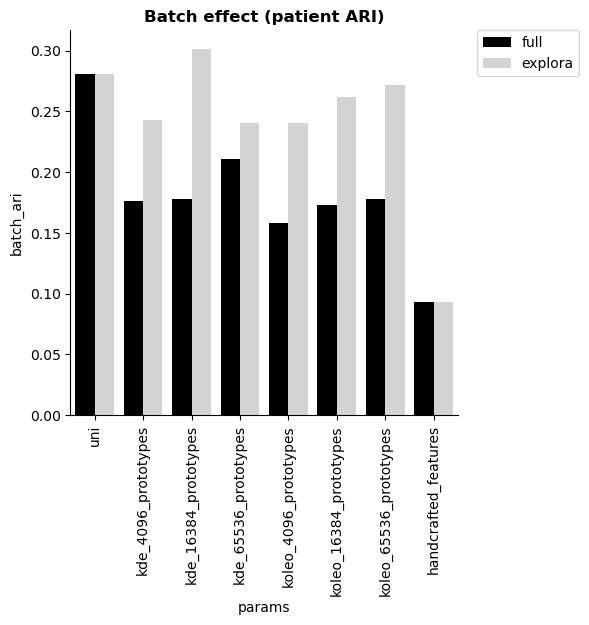

In [48]:
sns.barplot(data=df_batch, x="params", y="batch_ari", hue="model", palette={config['retrained_model_list2_type']: 'black', config['retrained_model_list1_type']: 'lightgray'})
sns.despine()
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Batch effect (patient ARI)", weight='bold')
plt.savefig(os.path.join(config["figures_folder"], "Figure3/batch_effect_full_vs_explora_models.pdf"), bbox_inches='tight')